## Credit Score Card Prediction

### Importing necessary libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split as split
import sklearn.metrics as metrics
from imblearn.under_sampling import RandomUnderSampler

### Reading CSV files

In [84]:
application_record = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')

### Exploring the data

In [85]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [86]:
application_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

### Checking for duplicate values

In [87]:
duplicates_bool = application_record.duplicated(subset='ID', keep=False)
print('There are',sum(duplicates_bool),'duplicates in ID column.')

There are 94 duplicates in ID column.


In [88]:
duplicates = application_record[duplicates_bool].sort_values('ID')
duplicates.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3


#### As the 47 duplicate values represents only 94 entries out of available rows, it is reasonable to exclude all duplicated observations for now.
This process has given a clean data frame of 438,463 unique customers' information.

In [89]:
application_record_unique = application_record.drop_duplicates(subset='ID', keep=False, inplace=False)

application_record_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438463 non-null  int64  
 1   CODE_GENDER          438463 non-null  object 
 2   FLAG_OWN_CAR         438463 non-null  object 
 3   FLAG_OWN_REALTY      438463 non-null  object 
 4   CNT_CHILDREN         438463 non-null  int64  
 5   AMT_INCOME_TOTAL     438463 non-null  float64
 6   NAME_INCOME_TYPE     438463 non-null  object 
 7   NAME_EDUCATION_TYPE  438463 non-null  object 
 8   NAME_FAMILY_STATUS   438463 non-null  object 
 9   NAME_HOUSING_TYPE    438463 non-null  object 
 10  DAYS_BIRTH           438463 non-null  int64  
 11  DAYS_EMPLOYED        438463 non-null  int64  
 12  FLAG_MOBIL           438463 non-null  int64  
 13  FLAG_WORK_PHONE      438463 non-null  int64  
 14  FLAG_PHONE           438463 non-null  int64  
 15  FLAG_EMAIL       

### Exploring the Credit Record Dataset

In [90]:
credit_record.info()
print('_'*50)
credit_record.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
__________________________________________________


ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

#### The Credit Record dataset contains 45,985 bank customers and encompasses up to 60 months of retroactive credit card billing history for each customer.

In [91]:
credit_decision = pd.DataFrame()
credit_decision['ID'] = credit_record['ID'].unique()

### As the definition of 'good' or 'bad' cleint is not given. Creating a model that predicts whether a customer's profile would lead to a credit card approval, the payment history of each customer will be categorized into three clusters as :- "Not Enough Data" (cluster -1), "Bad Payer" (cluster 0), and "Good Payer" (cluster 1).

In [92]:
def get_credit_decision(id):
    
    GOOD_STATUS = ['0']
    BAD_STATUS = ['1', '2', '3', '4', '5']
    UNUSED_STATUS = ['X']
    
    client_status = credit_record[credit_record['ID'] == id]['STATUS'].tolist()
    
    if any(status in BAD_STATUS for status in client_status):
        return 1
    
    elif all(status in UNUSED_STATUS for status in client_status):
        return -1
    
    else:
        return 0

#### Based on these interpretations, a new dataset "credit_decision" is created with two columns: the unique customer IDs with credit card history and their respective classification decisions (-1, 0, or 1).

### Creating a 'Decision' column in credit_decision dataset and calling get_credit_decision() to get correct cluster

In [93]:

credit_decision['Decision'] = credit_decision['ID'].map(get_credit_decision)

credit_decision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ID        45985 non-null  int64
 1   Decision  45985 non-null  int64
dtypes: int64(2)
memory usage: 718.6 KB


### Excludeing all customers without sufficient data (category -1) from credit_decision

In [94]:

credit_decision = credit_decision[credit_decision['Decision']!=-1]

In [95]:
credit_decision['Decision'].value_counts()

0    36099
1     5350
Name: Decision, dtype: int64

#### Excluding all customers without sufficient data, the dependent variable became a binary value, with 0 referring to a risky credit card profile and 1 referring to a low-risk profile which will be suitable for a credit card approval.

### The application_record and credit_decision data frames are joined by their intersection based on the common table customer ID numbers (Performing inner join).

In [96]:
join_data = pd.merge(credit_decision,application_record_unique)
join_data.head()

,ID,Decision,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
1,5008805,1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
2,5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
3,5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008810,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


In [97]:
join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33110 entries, 0 to 33109
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33110 non-null  int64  
 1   Decision             33110 non-null  int64  
 2   CODE_GENDER          33110 non-null  object 
 3   FLAG_OWN_CAR         33110 non-null  object 
 4   FLAG_OWN_REALTY      33110 non-null  object 
 5   CNT_CHILDREN         33110 non-null  int64  
 6   AMT_INCOME_TOTAL     33110 non-null  float64
 7   NAME_INCOME_TYPE     33110 non-null  object 
 8   NAME_EDUCATION_TYPE  33110 non-null  object 
 9   NAME_FAMILY_STATUS   33110 non-null  object 
 10  NAME_HOUSING_TYPE    33110 non-null  object 
 11  DAYS_BIRTH           33110 non-null  int64  
 12  DAYS_EMPLOYED        33110 non-null  int64  
 13  FLAG_MOBIL           33110 non-null  int64  
 14  FLAG_WORK_PHONE      33110 non-null  int64  
 15  FLAG_PHONE           33110 non-null 

In [98]:
columns = join_data.columns.difference(['ID'])
join_data['INFO'] = join_data[columns].apply(lambda x: '_'.join(x.map(str)), axis=1)
join_data['INFO'].nunique()

10927

In [99]:
join_data['INFO'].value_counts().sort_values(ascending=False).head(1)

297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Secondary / secondary special_Single / not married_Rented apartment_Commercial associate_Laborers    38
Name: INFO, dtype: int64

In [100]:
join_data[join_data['INFO']=='297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Secondary / secondary special_Single / not married_Rented apartment_Commercial associate_Laborers']

,ID,Decision,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,INFO
69,5008891,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
70,5008892,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
71,5008893,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
72,5008894,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
73,5008895,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
74,5008896,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
75,5008897,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
76,5008898,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
77,5008899,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...
78,5008900,0,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1,297000.0_0_1_F_-15519_-3234_0_0_1_N_Y_0_0_Seco...


In [101]:
unique_join_data = join_data.drop_duplicates(subset='INFO', keep='first')
unique_join_data.drop('INFO', axis=1, inplace=True)
unique_join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10927 entries, 0 to 33105
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10927 non-null  int64  
 1   Decision             10927 non-null  int64  
 2   CODE_GENDER          10927 non-null  object 
 3   FLAG_OWN_CAR         10927 non-null  object 
 4   FLAG_OWN_REALTY      10927 non-null  object 
 5   CNT_CHILDREN         10927 non-null  int64  
 6   AMT_INCOME_TOTAL     10927 non-null  float64
 7   NAME_INCOME_TYPE     10927 non-null  object 
 8   NAME_EDUCATION_TYPE  10927 non-null  object 
 9   NAME_FAMILY_STATUS   10927 non-null  object 
 10  NAME_HOUSING_TYPE    10927 non-null  object 
 11  DAYS_BIRTH           10927 non-null  int64  
 12  DAYS_EMPLOYED        10927 non-null  int64  
 13  FLAG_MOBIL           10927 non-null  int64  
 14  FLAG_WORK_PHONE      10927 non-null  int64  
 15  FLAG_PHONE           10927 non-null 

C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Handling the Null Data

In [102]:
unique_join_data.isnull().sum()

ID                        0
Decision                  0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        3359
CNT_FAM_MEMBERS           0
dtype: int64

In [103]:
unique_join_data[['DAYS_EMPLOYED']][unique_join_data['OCCUPATION_TYPE'].isnull()].value_counts()

DAYS_EMPLOYED
 365243          1877
-857                8
-229                6
-401                5
-279                5
                 ... 
-1844               1
-1858               1
-1871               1
-1881               1
-15227              1
Length: 1029, dtype: int64

In [104]:
unique_join_data[unique_join_data['DAYS_EMPLOYED']==365243]['OCCUPATION_TYPE']
unique_join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10927 entries, 0 to 33105
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10927 non-null  int64  
 1   Decision             10927 non-null  int64  
 2   CODE_GENDER          10927 non-null  object 
 3   FLAG_OWN_CAR         10927 non-null  object 
 4   FLAG_OWN_REALTY      10927 non-null  object 
 5   CNT_CHILDREN         10927 non-null  int64  
 6   AMT_INCOME_TOTAL     10927 non-null  float64
 7   NAME_INCOME_TYPE     10927 non-null  object 
 8   NAME_EDUCATION_TYPE  10927 non-null  object 
 9   NAME_FAMILY_STATUS   10927 non-null  object 
 10  NAME_HOUSING_TYPE    10927 non-null  object 
 11  DAYS_BIRTH           10927 non-null  int64  
 12  DAYS_EMPLOYED        10927 non-null  int64  
 13  FLAG_MOBIL           10927 non-null  int64  
 14  FLAG_WORK_PHONE      10927 non-null  int64  
 15  FLAG_PHONE           10927 non-null 

In [105]:
def transform_days(value):
    return -value if value < 0 else 0

In [106]:
unique_join_data['DAYS_EMPLOYED'] = unique_join_data['DAYS_EMPLOYED'].apply(transform_days)

<ipython-input-106-85d5618f5f95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_join_data['DAYS_EMPLOYED'] = unique_join_data['DAYS_EMPLOYED'].apply(transform_days)


In [107]:
unique_join_data.loc[unique_join_data['DAYS_EMPLOYED'] == 0, 'OCCUPATION_TYPE'] = 'not_working'

C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [108]:
unique_join_data.isnull().sum()

ID                        0
Decision                  0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        1482
CNT_FAM_MEMBERS           0
dtype: int64

In [109]:
non_null_data = unique_join_data.fillna('Unknown')
non_null_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10927 entries, 0 to 33105
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10927 non-null  int64  
 1   Decision             10927 non-null  int64  
 2   CODE_GENDER          10927 non-null  object 
 3   FLAG_OWN_CAR         10927 non-null  object 
 4   FLAG_OWN_REALTY      10927 non-null  object 
 5   CNT_CHILDREN         10927 non-null  int64  
 6   AMT_INCOME_TOTAL     10927 non-null  float64
 7   NAME_INCOME_TYPE     10927 non-null  object 
 8   NAME_EDUCATION_TYPE  10927 non-null  object 
 9   NAME_FAMILY_STATUS   10927 non-null  object 
 10  NAME_HOUSING_TYPE    10927 non-null  object 
 11  DAYS_BIRTH           10927 non-null  int64  
 12  DAYS_EMPLOYED        10927 non-null  int64  
 13  FLAG_MOBIL           10927 non-null  int64  
 14  FLAG_WORK_PHONE      10927 non-null  int64  
 15  FLAG_PHONE           10927 non-null 

In [110]:
non_null_data['CNT_ADULTS'] = non_null_data['CNT_FAM_MEMBERS'] - non_null_data['CNT_CHILDREN']
non_null_data['CNT_ADULTS'].value_counts()

 2    8339
 1    2580
 0       6
-1       2
Name: CNT_ADULTS, dtype: int64

In [111]:
inconsistent_family_entries = non_null_data[non_null_data['CNT_ADULTS'] <= 0]
inconsistent_family_entries


,ID,Decision,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CNT_ADULTS
1517,5010869,1,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18173,678,1,0,1,1,Core staff,1,0
3462,5023641,1,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,2212,1,0,0,0,Drivers,1,-1
8968,5045457,1,M,Y,N,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14452,4249,1,0,0,0,Drivers,1,-1
11239,5053148,1,F,N,Y,1,126000.0,Working,Secondary / secondary special,Married,House / apartment,-12140,779,1,0,0,0,Core staff,1,0
11889,5054068,1,M,N,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-16424,1458,1,0,0,0,Drivers,1,0
18770,5089953,1,M,N,Y,1,126000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-12755,2105,1,0,0,0,Unknown,1,0
30766,5142973,1,M,N,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,-10656,926,1,1,1,0,Laborers,1,0
31504,5146078,1,F,N,Y,1,108000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-12723,1132,1,1,1,0,Sales staff,1,0


In [112]:
non_null_data = non_null_data.drop(inconsistent_family_entries.index)

In [113]:
non_null_data['CNT_ADULTS'].value_counts()

2    8339
1    2580
Name: CNT_ADULTS, dtype: int64

In [114]:
non_null_data['DAYS_BIRTH'] = -non_null_data['DAYS_BIRTH']
non_null_data['DAYS_BIRTH']

0        12005
2        21474
3        19110
6        22464
9        16872
         ...  
33092    14234
33095    14234
33097    17713
33104    12414
33105    10808
Name: DAYS_BIRTH, Length: 10919, dtype: int64

In [115]:
credit_data = non_null_data.drop(['ID','CODE_GENDER', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10919 entries, 0 to 33105
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Decision             10919 non-null  int64  
 1   FLAG_OWN_CAR         10919 non-null  object 
 2   FLAG_OWN_REALTY      10919 non-null  object 
 3   CNT_CHILDREN         10919 non-null  int64  
 4   AMT_INCOME_TOTAL     10919 non-null  float64
 5   NAME_INCOME_TYPE     10919 non-null  object 
 6   NAME_EDUCATION_TYPE  10919 non-null  object 
 7   NAME_FAMILY_STATUS   10919 non-null  object 
 8   NAME_HOUSING_TYPE    10919 non-null  object 
 9   DAYS_BIRTH           10919 non-null  int64  
 10  DAYS_EMPLOYED        10919 non-null  int64  
 11  OCCUPATION_TYPE      10919 non-null  object 
 12  CNT_FAM_MEMBERS      10919 non-null  int64  
 13  CNT_ADULTS           10919 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.2+ MB


In [116]:
credit_data['AMT_INCOME_PER_CHILDREN'] = np.where(credit_data['CNT_CHILDREN'] > 0, credit_data['AMT_INCOME_TOTAL']/credit_data['CNT_CHILDREN'],0)
credit_data['AMT_INCOME_PER_CHILDREN'].describe()

count    1.091900e+04
mean     4.661820e+04
std      9.313060e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.750000e+04
max      1.575000e+06
Name: AMT_INCOME_PER_CHILDREN, dtype: float64

In [117]:
credit_data['AMT_INCOME_PER_FAM_MEMBER'] = credit_data['AMT_INCOME_TOTAL']/credit_data['CNT_FAM_MEMBERS']
credit_data['AMT_INCOME_PER_FAM_MEMBER'].describe()

count     10919.000000
mean      98905.223634
std       71737.149367
min        5625.000000
25%       52875.000000
50%       78750.000000
75%      123750.000000
max      900000.000000
Name: AMT_INCOME_PER_FAM_MEMBER, dtype: float64

In [118]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10919 entries, 0 to 33105
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Decision                   10919 non-null  int64  
 1   FLAG_OWN_CAR               10919 non-null  object 
 2   FLAG_OWN_REALTY            10919 non-null  object 
 3   CNT_CHILDREN               10919 non-null  int64  
 4   AMT_INCOME_TOTAL           10919 non-null  float64
 5   NAME_INCOME_TYPE           10919 non-null  object 
 6   NAME_EDUCATION_TYPE        10919 non-null  object 
 7   NAME_FAMILY_STATUS         10919 non-null  object 
 8   NAME_HOUSING_TYPE          10919 non-null  object 
 9   DAYS_BIRTH                 10919 non-null  int64  
 10  DAYS_EMPLOYED              10919 non-null  int64  
 11  OCCUPATION_TYPE            10919 non-null  object 
 12  CNT_FAM_MEMBERS            10919 non-null  int64  
 13  CNT_ADULTS                 10919 non-null  int

### Factorizing categorical variables which will allow the Random Forest Classifier to assemble decision trees based on numerical rules (larger or smaller). Such a model can deal well with numeric categorical variables without needing them to be transformed into dummy variables.

In [119]:
categorical_columns = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
categorical_data = credit_data[categorical_columns]

numerical_categorical_data = categorical_data.apply(lambda x: pd.factorize(x)[0])
numerical_categorical_data = pd.DataFrame(numerical_categorical_data)

numerical_categorical_data.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1
3,1,0,1,1,2,1,2
6,1,0,2,0,3,1,3
9,0,0,0,0,1,1,4


#### Each category was associated with an integer number. So, the feature CODE_GENDER, which previously contained "M" for males and "F" for females, now has 0 and 1.

### Updating the values of categorical variables into credit_data data frame

In [120]:
credit_data[categorical_columns] = numerical_categorical_data
credit_data.head()

,Decision,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CNT_ADULTS,AMT_INCOME_PER_CHILDREN,AMT_INCOME_PER_FAM_MEMBER
0,1,0,0,0,427500.0,0,0,0,0,12005,4542,0,2,2,0.0,213750.0
2,0,0,0,0,112500.0,0,1,1,1,21474,1134,1,2,2,0.0,56250.0
3,0,1,0,0,270000.0,1,1,2,1,19110,3051,2,1,1,0.0,270000.0
6,0,1,0,0,283500.0,2,0,3,1,22464,0,3,1,1,0.0,283500.0
9,0,0,0,0,270000.0,0,0,1,1,16872,769,4,2,2,0.0,135000.0


### Handling Imbalance Data

In [121]:
credit_decision['Decision'].value_counts(normalize=True)

0    0.870926
1    0.129074
Name: Decision, dtype: float64

<ipython-input-122-561184f6764a>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


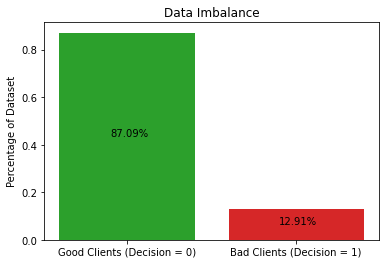

In [122]:
fig, ax = plt.subplots()

client = ['Good Clients (Decision = 0)','Bad Clients (Decision = 1)']
proportions = credit_decision['Decision'].value_counts(normalize=True)
bar_colors = ['tab:green','tab:red']

ax.bar(client, proportions, color=bar_colors)

ax.set_ylabel('Percentage of Dataset')
ax.set_title('Data Imbalance')

ax.text(1-0.1, proportions[1]/2, '{:.2%}'.format(proportions[1]), size=10)
ax.text(0-0.1, proportions[0]/2, '{:.2%}'.format(proportions[0]), size=10)

fig.show()

In [123]:
credit_data.to_csv('credit_data.csv')

### Building The Random Forest Classifier Model

#### The data for building the model were randomly divided into a training group with 80% of the data and a test group with the rest 20%.

In [124]:
y = credit_data['Decision']
X = credit_data.drop(['Decision'], axis=1)
unbal_X_train, X_test, unbal_y_train, y_test = split(X, y, test_size=0.2, random_state=0)

<ipython-input-125-dd2df42b834a>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


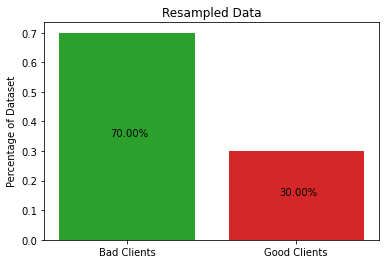

In [125]:
rus = RandomUnderSampler(sampling_strategy=(3/7), random_state=0)
rus_X_train, rus_y_train = rus.fit_resample(unbal_X_train, unbal_y_train)

fig, ax = plt.subplots()
client = ['Bad Clients','Good Clients']
proportions = rus_y_train.value_counts(normalize=True)
bar_colors = ['tab:green', 'tab:red']
ax.bar(client, proportions, color=bar_colors)
ax.set_ylabel('Percentage of Dataset')
ax.set_title('Resampled Data')
ax.text(1-0.1, proportions[1]/2, '{:.2%}'.format(proportions[1]), size=10)
ax.text(0-0.1, proportions[0]/2, '{:.2%}'.format(proportions[0]), size=10)

fig.show()

In [126]:
unbal_rf = RFC( n_estimators = 1000, max_features = 8, random_state=0)
unbal_rf.fit(unbal_X_train, unbal_y_train)

RandomForestClassifier(max_features=8, n_estimators=1000, random_state=0)

In [127]:
rus_rf = RFC( n_estimators = 1000, max_features = 8, random_state=0)
rus_rf.fit(rus_X_train, rus_y_train)

RandomForestClassifier(max_features=8, n_estimators=1000, random_state=0)

### The model is accurate about 87.68% when the output is "yes", and when the model tried to answer, it is about 96.12% accurate. On the other hand it wasn't good enough for the model to say "no", as the model is only 32.15% right, where the overall result, F1 score is 93.12%.

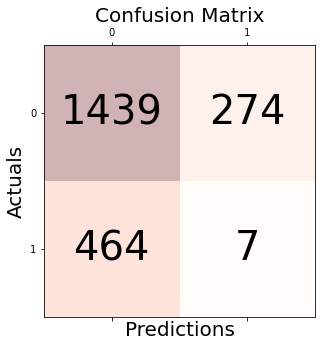

Accuracy: 66.21%
Precision: 2.49%
Recall: 1.49%
Specificity: 84.00%
F1: 1.86%


In [128]:
y_pred = unbal_rf.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='40')
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actuals', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

print('Accuracy:', '{:.2%}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision:', '{:.2%}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall:', '{:.2%}'.format(metrics.recall_score(y_test, y_pred)))
print('Specificity:', '{:.2%}'.format((conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])))
print('F1:', '{:.2%}'.format(metrics.f1_score(y_test, y_pred)))

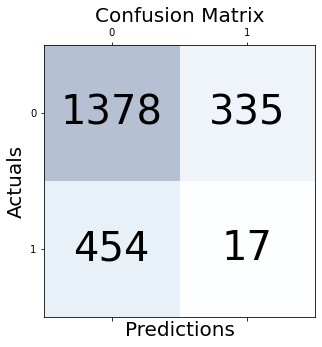

Accuracy: 63.87%
Precision: 4.83%
Recall: 3.61%
Specificity: 80.44%
F1: 4.13%


In [129]:
y_pred = rus_rf.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='40')
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actuals', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

print('Accuracy:', '{:.2%}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision:', '{:.2%}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall:', '{:.2%}'.format(metrics.recall_score(y_test, y_pred)))
print('Specificity:', '{:.2%}'.format((conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])))
print('F1:', '{:.2%}'.format(metrics.f1_score(y_test, y_pred)))

### Calculating Feature Importance for Unbalanced Model

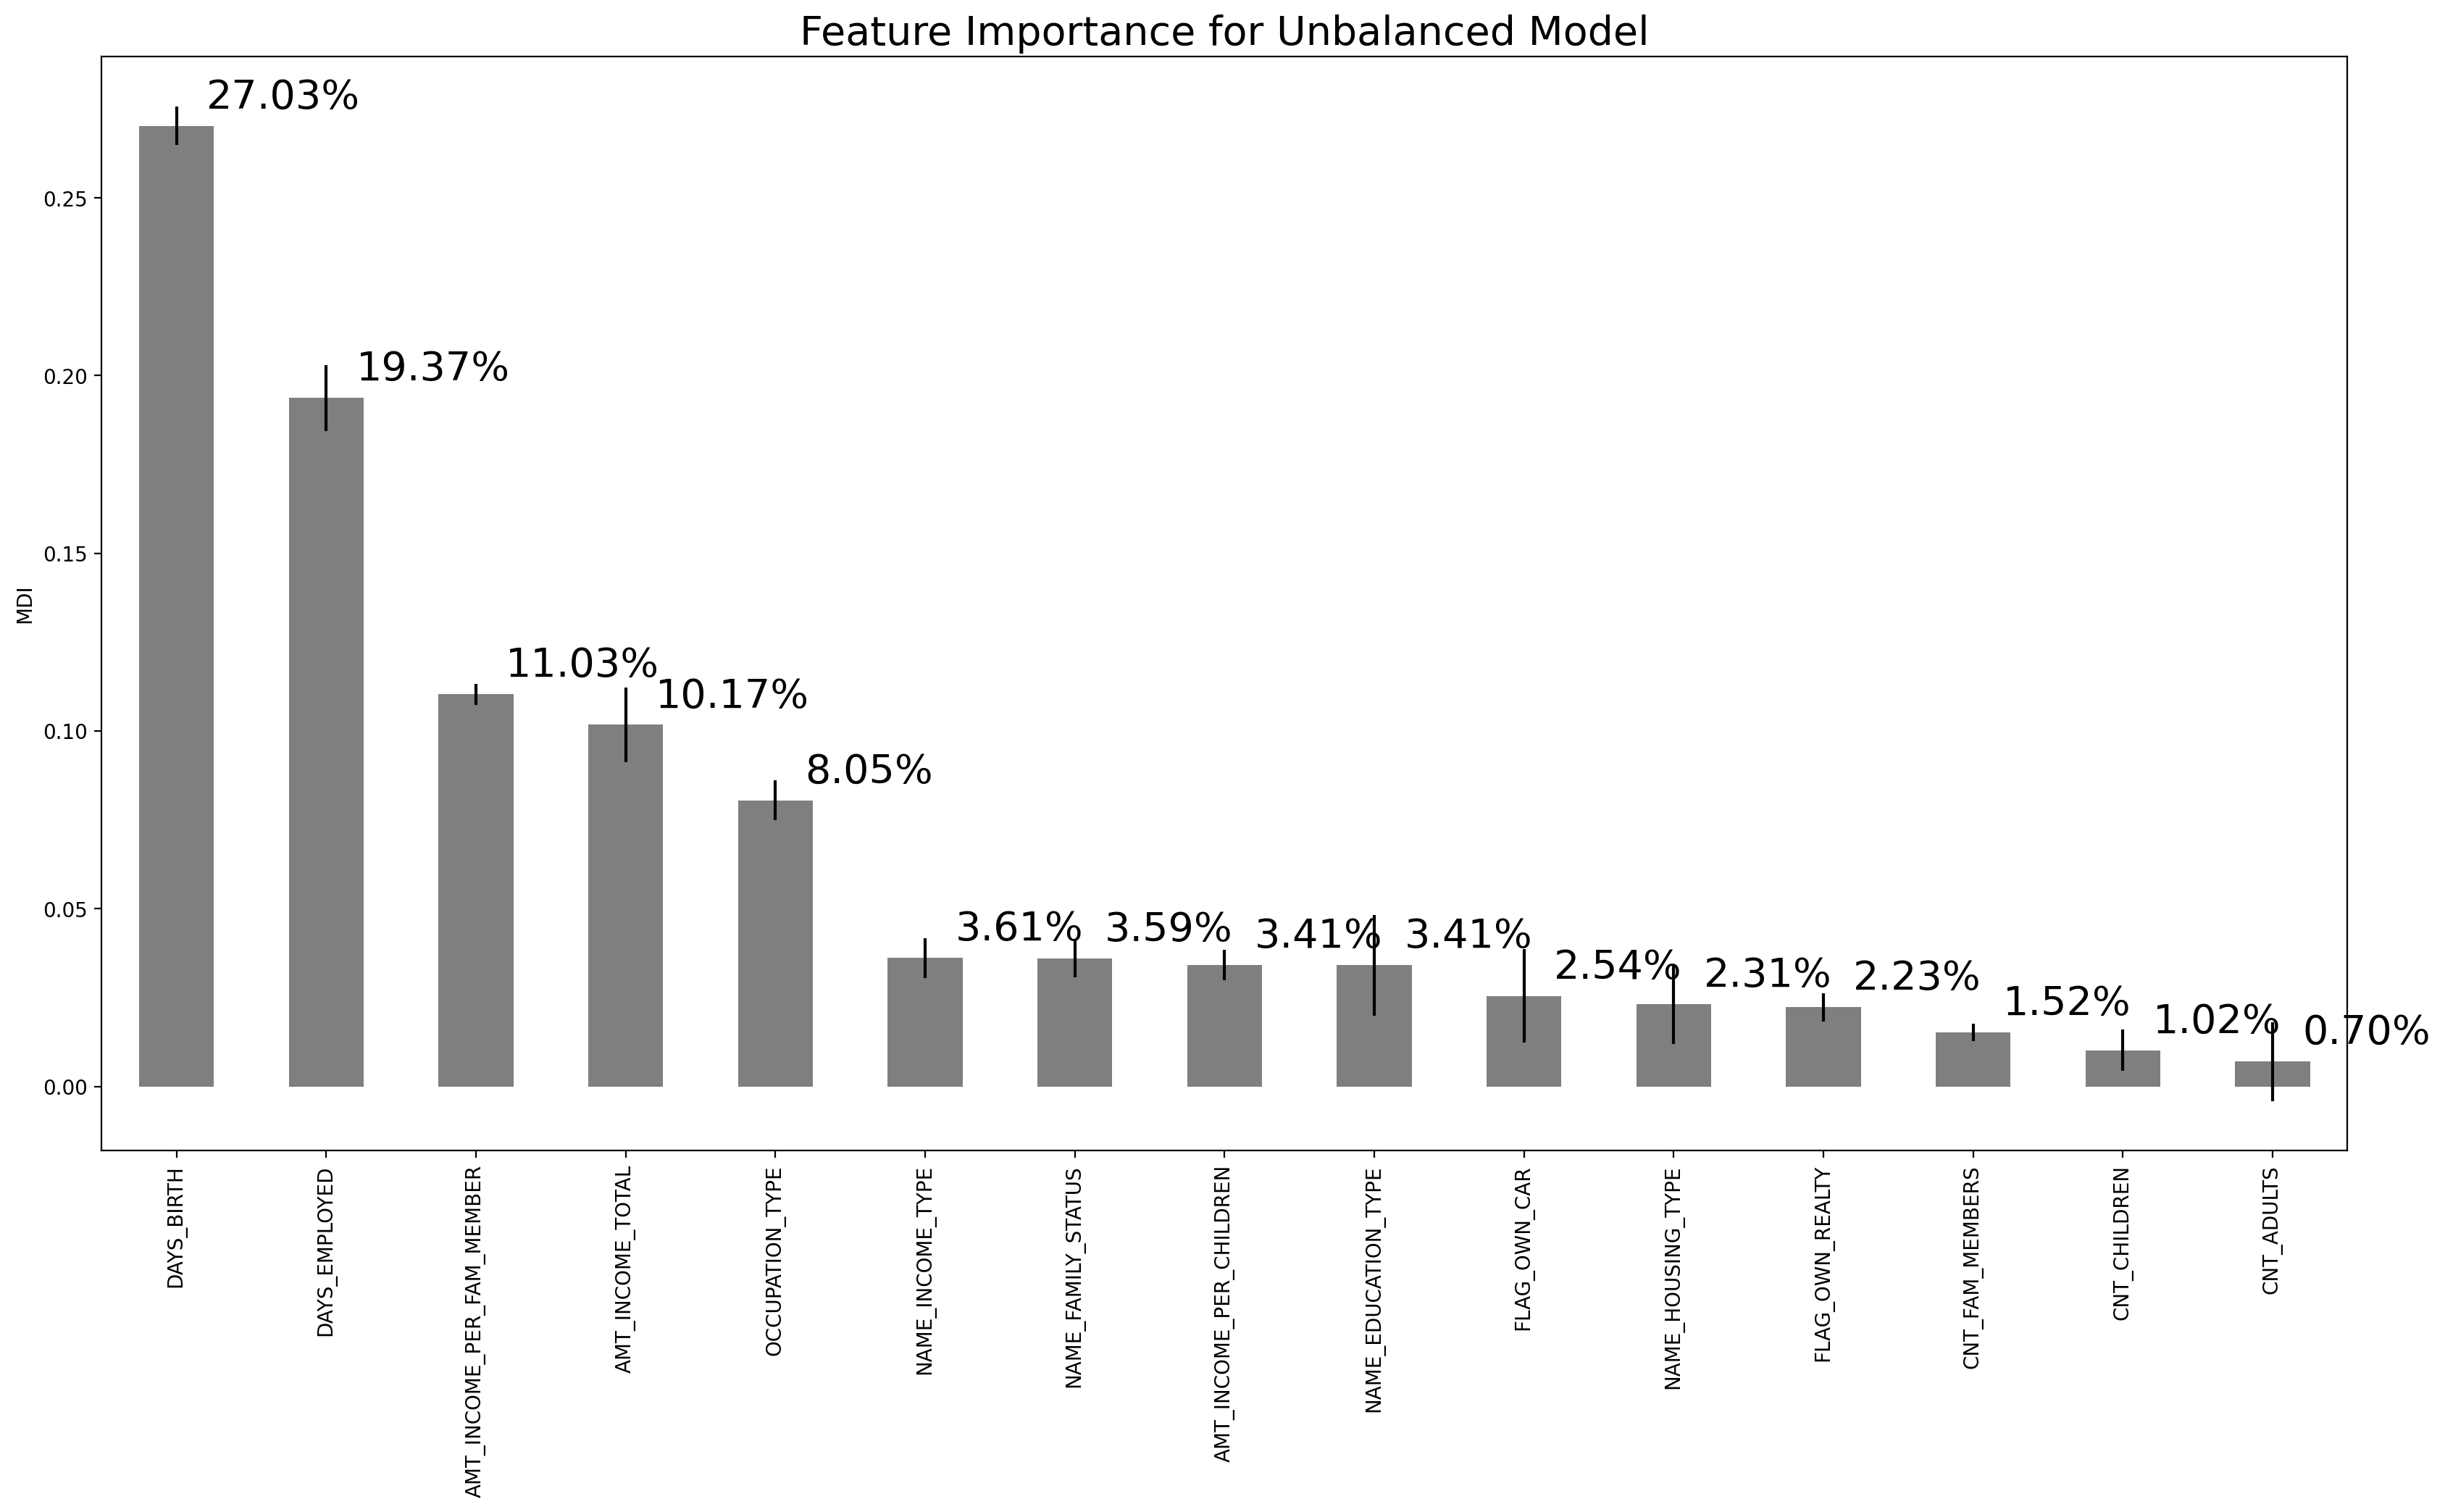

In [130]:
std = np.std([tree.feature_importances_ for tree in unbal_rf.estimators_], axis=0)
importances = pd.Series(unbal_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
importances.plot.bar(yerr=std, ax=ax, color='tab:gray')
ax.set_title("Feature Importance for Unbalanced Model", size=20)
ax.set_ylabel("MDI")
for i in range(len(X.columns)):
  ax.text(i+0.2, importances[i]+0.005, '{:.2%}'.format(importances[i]), size=20)
fig.set_size_inches(20, 10)
fig.set_dpi(200)

### Calculating Feature Importance for Random Under Sampler Model 

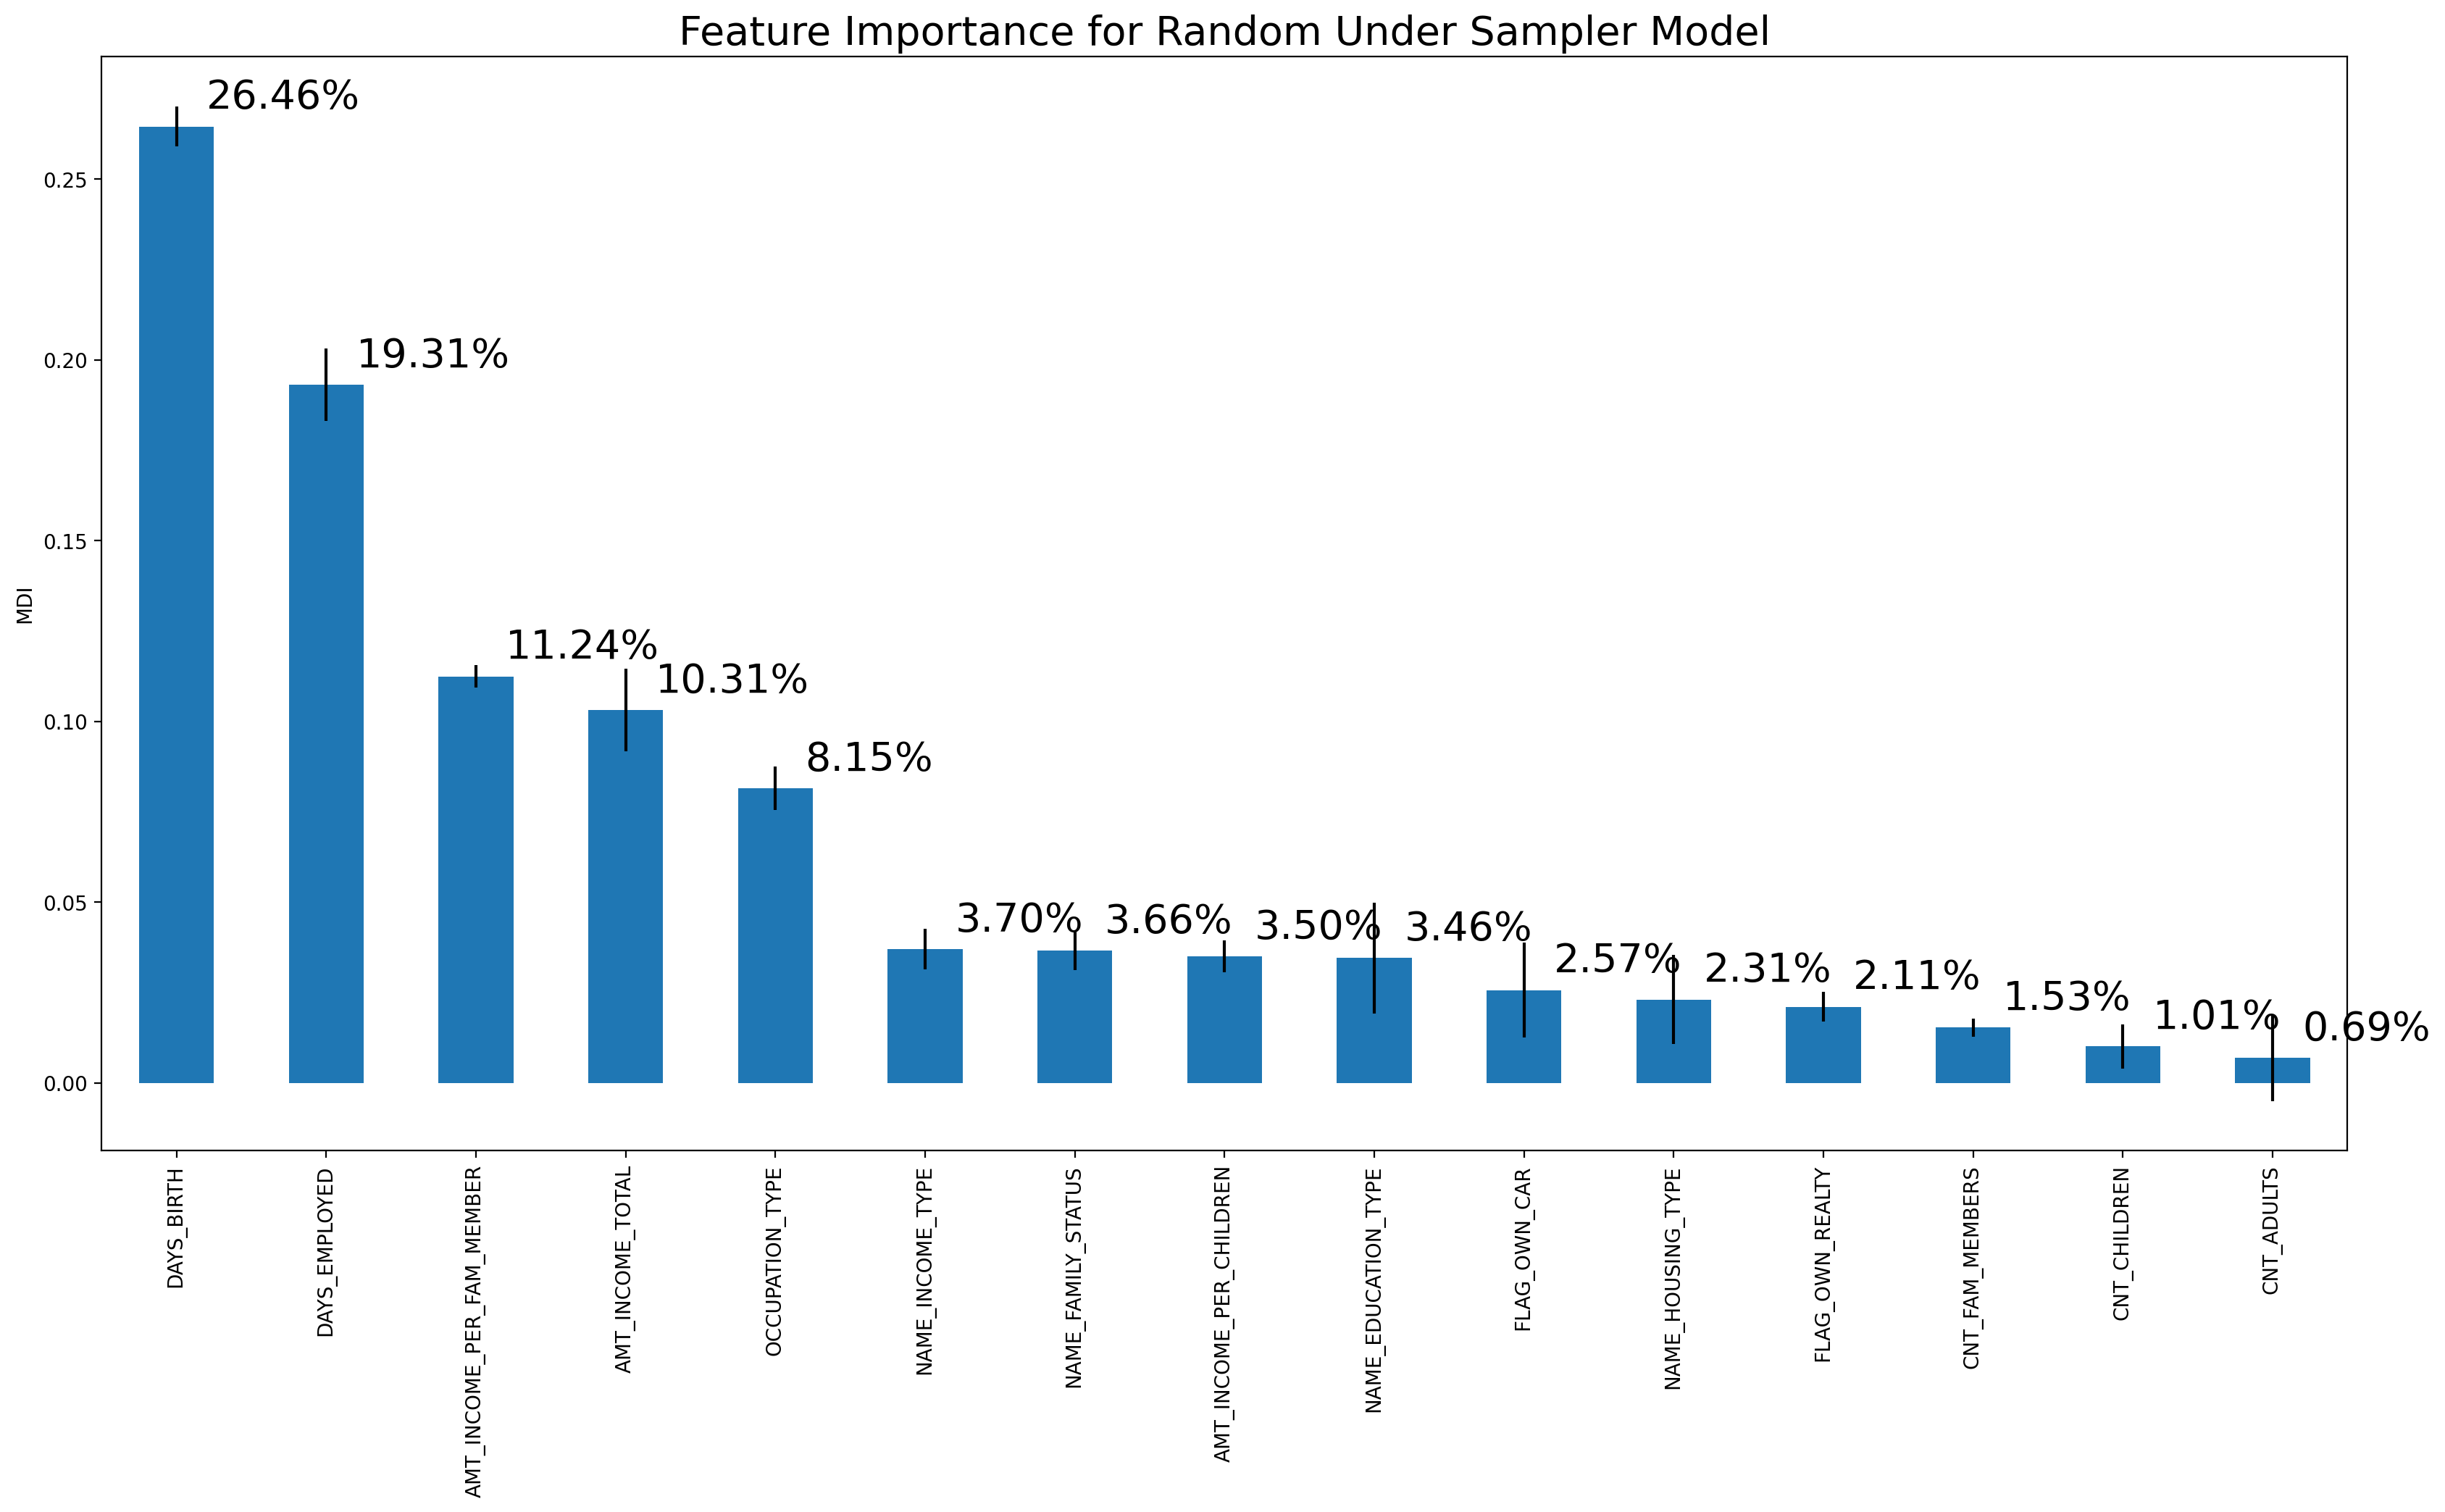

In [131]:
std = np.std([tree.feature_importances_ for tree in rus_rf.estimators_], axis=0)
importances = pd.Series(rus_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Random Under Sampler Model", size=20)
ax.set_ylabel("MDI")
for i in range(len(X.columns)):
  ax.text(i+0.2, importances[i]+0.005, '{:.2%}'.format(importances[i]), size=20)
fig.set_size_inches(20, 10)
fig.set_dpi(200)

### Conclusion - 

### The model is quite good at saying "Yes" to the "Good Client" (90.31% of its "yes" being correct). Many of the real "Yes" are about 96.12% accurate. However, it struggled a bit in saying "No" for "Bad Clients" correctly as only 32.15% of its "No" answers being right. The overall F1 Score is 93.12%, which has concluded that the model did well in balancing everything.